# Homework part I

The first problem set contains basic tasks in pytorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to pytorch or pytorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in pytorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [37]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
print(torch.__version__)

0.4.1


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

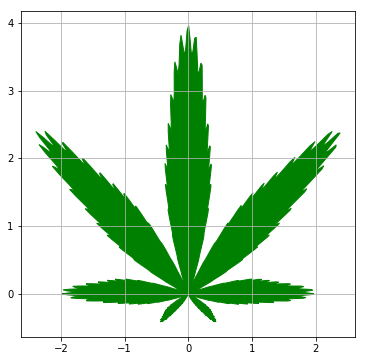

In [3]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * \
    (1 + 0.1 * torch.cos(24 * theta)) * \
    (0.9 + 0.05 * torch.cos(200 * theta)) * \
    (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
_[numpy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [4]:
from scipy.signal import convolve2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = convolve2d(Z,filters,mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    return Z

In [31]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    Z_new = torch.ones(1, 1, Z.shape[0], Z.shape[1])
    Z_new[0][0] = Z
    Z_new = torch.autograd.Variable(Z_new)
    
    filters = torch.from_numpy(
        np.array([[1,1,1],
                  [1,0,1],
                  [1,1,1]])
    )
    filters_new = torch.ones(1, 1, filters.shape[0], filters.shape[1])
    filters_new[0][0] = filters
    filters_new = torch.autograd.Variable(filters_new)

    N = torch.nn.functional.conv2d(Z_new, filters_new, padding=1)
    N = N.data[0][0]

#     print(N) #del
    
    Z = Z_new.data[0][0]
    
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)

    Z[:] = birth | survive
    
    return Z

In [32]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


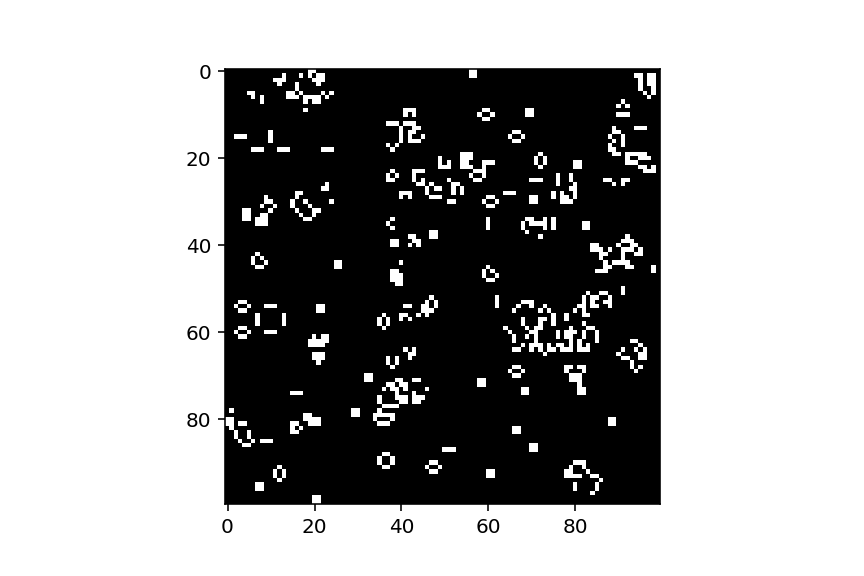

In [33]:
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    
    #update
    Z = torch_update(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()


<IPython.core.display.Javascript object>


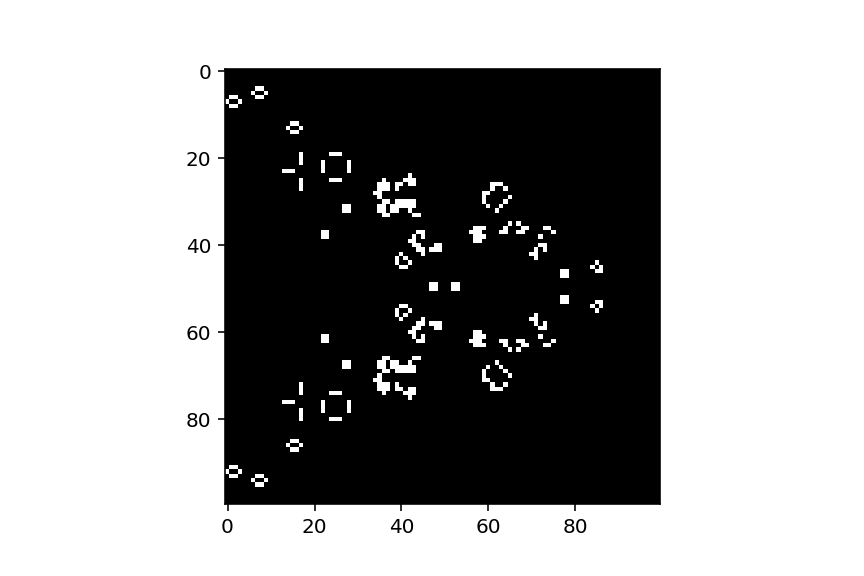

In [34]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52,50]=1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

```

```

```

```

```

```

```

```

```

```



### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your third trial is to build your first neural network [almost] from scratch and pure torch.

This time you will solve yet another digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](https://www.kaggle.com/wiki/LogLoss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [35]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


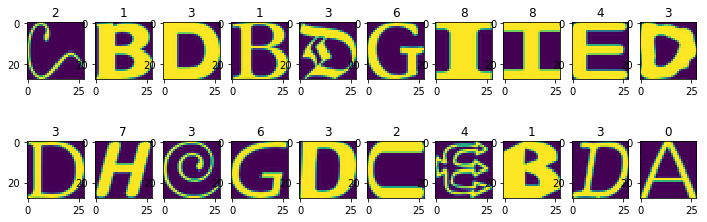

In [36]:
%matplotlib inline
plt.figure(figsize=[12,4])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

In [ ]:
#< a whole lot of your code > 

In [38]:
#copy-paste from week03
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]
        
def compute_loss(model, X_batch, y_batch, use_cross_entropy=False):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    if use_cross_entropy:
        return F.cross_entropy(logits, y_batch).mean()
    return F.nll_loss(logits, y_batch).mean()

In [84]:
#copy-paste from week03
def train(model, X_train, y_train, X_val, y_val, num_epochs=500, batch_size=256, use_cross_entropy=False):
    train_loss = []
    val_accuracy = []
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(model, X_batch, y_batch, use_cross_entropy)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.numpy())
        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(Variable(torch.FloatTensor(X_batch)))
            y_pred = logits.max(1)[1].data.numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))


        # Then we print the results for this epoch:
        if (epoch + 1) % 10 == 0:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(
                np.mean(train_loss[-len(X_train) // batch_size :])))
            print("  validation accuracy: \t\t\t{:.2f} %".format(
                np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
            print()

In [71]:
#copy-paste from week03
def final_test_accuracy(model, X_test, y_test):
    model.train(False)
    logits = model(Variable(torch.FloatTensor(X_test)))
    y_pred = logits.max(1)[1].data.numpy()
    test_accuracy = np.mean(y_test == y_pred)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

In [72]:
model = nn.Sequential()
model.add_module('l_linear', nn.Linear(X_train.shape[1], 10))

In [85]:
train(model, X_train, y_train, X_test, y_test, use_cross_entropy=True)

Epoch 10 of 500 took 0.132s
  training loss (in-iteration): 	1.730322
  validation accuracy: 			71.41 %

Epoch 20 of 500 took 0.132s
  training loss (in-iteration): 	1.728547
  validation accuracy: 			71.18 %

Epoch 30 of 500 took 0.134s
  training loss (in-iteration): 	1.727041
  validation accuracy: 			71.54 %

Epoch 40 of 500 took 0.123s
  training loss (in-iteration): 	1.725473
  validation accuracy: 			71.37 %

Epoch 50 of 500 took 0.138s
  training loss (in-iteration): 	1.723986
  validation accuracy: 			71.43 %

Epoch 60 of 500 took 0.130s
  training loss (in-iteration): 	1.722301
  validation accuracy: 			71.61 %

Epoch 70 of 500 took 0.126s
  training loss (in-iteration): 	1.720406
  validation accuracy: 			71.39 %

Epoch 80 of 500 took 0.130s
  training loss (in-iteration): 	1.691786
  validation accuracy: 			77.37 %

Epoch 90 of 500 took 0.122s
  training loss (in-iteration): 	1.653780
  validation accuracy: 			80.17 %

Epoch 100 of 500 took 0.142s
  training loss (in-iterat

In [86]:
final_test_accuracy(model, X_test, y_test)

Final results:
  test accuracy:		90.41 %


In [87]:
model = nn.Sequential()
model.add_module('l_linear', nn.Linear(X_train.shape[1], 10))
model.add_module('l_softmax', nn.Softmax(dim=1))

In [88]:
train(model, X_train, y_train, X_test, y_test)

Epoch 10 of 500 took 0.039s
  training loss (in-iteration): 	-0.789412
  validation accuracy: 			84.61 %

Epoch 20 of 500 took 0.040s
  training loss (in-iteration): 	-0.826085
  validation accuracy: 			85.81 %

Epoch 30 of 500 took 0.043s
  training loss (in-iteration): 	-0.840525
  validation accuracy: 			86.90 %

Epoch 40 of 500 took 0.043s
  training loss (in-iteration): 	-0.849137
  validation accuracy: 			86.55 %

Epoch 50 of 500 took 0.043s
  training loss (in-iteration): 	-0.855112
  validation accuracy: 			86.76 %

Epoch 60 of 500 took 0.043s
  training loss (in-iteration): 	-0.859576
  validation accuracy: 			87.22 %

Epoch 70 of 500 took 0.042s
  training loss (in-iteration): 	-0.863309
  validation accuracy: 			87.52 %

Epoch 80 of 500 took 0.048s
  training loss (in-iteration): 	-0.866113
  validation accuracy: 			87.78 %

Epoch 90 of 500 took 0.043s
  training loss (in-iteration): 	-0.868920
  validation accuracy: 			87.93 %

Epoch 100 of 500 took 0.047s
  training loss (

In [89]:
final_test_accuracy(model, X_test, y_test)

Final results:
  test accuracy:		89.21 %


In [90]:
model = nn.Sequential()
model.add_module('l_linear_1', nn.Linear(X_train.shape[1], 100))
model.add_module('a_relu_1', nn.ReLU())
model.add_module('l_linear_2', nn.Linear(100, 10))
model.add_module('a_relu_2', nn.ReLU())
model.add_module('l_softmax', nn.Softmax(dim=1))

In [91]:
train(model, X_train, y_train, X_test, y_test)

Epoch 10 of 500 took 0.104s
  training loss (in-iteration): 	-0.360997
  validation accuracy: 			54.34 %

Epoch 20 of 500 took 0.106s
  training loss (in-iteration): 	-0.628323
  validation accuracy: 			70.71 %

Epoch 30 of 500 took 0.106s
  training loss (in-iteration): 	-0.731885
  validation accuracy: 			77.34 %

Epoch 40 of 500 took 0.104s
  training loss (in-iteration): 	-0.755294
  validation accuracy: 			78.09 %

Epoch 50 of 500 took 0.103s
  training loss (in-iteration): 	-0.766958
  validation accuracy: 			78.89 %

Epoch 60 of 500 took 0.104s
  training loss (in-iteration): 	-0.774538
  validation accuracy: 			79.02 %

Epoch 70 of 500 took 0.105s
  training loss (in-iteration): 	-0.780138
  validation accuracy: 			79.46 %

Epoch 80 of 500 took 0.111s
  training loss (in-iteration): 	-0.784526
  validation accuracy: 			79.38 %

Epoch 90 of 500 took 0.108s
  training loss (in-iteration): 	-0.788148
  validation accuracy: 			79.63 %

Epoch 100 of 500 took 0.112s
  training loss (

In [92]:
final_test_accuracy(model, X_test, y_test)

Final results:
  test accuracy:		81.95 %


In [93]:
model = nn.Sequential()
model.add_module('l_lienar_1', nn.Linear(X_train.shape[1], 100))
model.add_module('a_relu_1', nn.ReLU())
model.add_module('l_linear_2', nn.Linear(100, 50))
model.add_module('a_relu_2', nn.ReLU())
model.add_module('l_linear_3', nn.Linear(50, 10))
model.add_module('a_relu_3', nn.ReLU())
model.add_module('l_softmax', nn.Softmax(dim=1))

In [94]:
train(model, X_train, y_train, X_test, y_test)

Epoch 10 of 500 took 0.126s
  training loss (in-iteration): 	-0.110343
  validation accuracy: 			26.75 %

Epoch 20 of 500 took 0.134s
  training loss (in-iteration): 	-0.208264
  validation accuracy: 			28.99 %

Epoch 30 of 500 took 0.121s
  training loss (in-iteration): 	-0.330386
  validation accuracy: 			37.39 %

Epoch 40 of 500 took 0.124s
  training loss (in-iteration): 	-0.445833
  validation accuracy: 			44.21 %

Epoch 50 of 500 took 0.131s
  training loss (in-iteration): 	-0.549013
  validation accuracy: 			59.40 %

Epoch 60 of 500 took 0.124s
  training loss (in-iteration): 	-0.603597
  validation accuracy: 			61.25 %

Epoch 70 of 500 took 0.125s
  training loss (in-iteration): 	-0.616778
  validation accuracy: 			61.31 %

Epoch 80 of 500 took 0.124s
  training loss (in-iteration): 	-0.623480
  validation accuracy: 			62.18 %

Epoch 90 of 500 took 0.123s
  training loss (in-iteration): 	-0.628122
  validation accuracy: 			61.94 %

Epoch 100 of 500 took 0.127s
  training loss (

In [95]:
final_test_accuracy(model, X_test, y_test)

Final results:
  test accuracy:		72.25 %


In [96]:
model = nn.Sequential()
model.add_module('l_linear_1', nn.Linear(X_train.shape[1], 300))
model.add_module('a_relu_1', nn.ReLU())
model.add_module('bn_1', nn.BatchNorm1d(300))
model.add_module('l_linear_2', nn.Linear(300, 100))
model.add_module('a_relu_2', nn.ReLU())
model.add_module('bn_2', nn.BatchNorm1d(100))
model.add_module('l_linear_3', nn.Linear(100, 10))
model.add_module('l_softmax', nn.Softmax(dim=1))

In [97]:
train(model, X_train, y_train, X_test, y_test)

Epoch 10 of 500 took 0.478s
  training loss (in-iteration): 	-0.653506
  validation accuracy: 			79.72 %

Epoch 20 of 500 took 0.467s
  training loss (in-iteration): 	-0.806731
  validation accuracy: 			87.39 %

Epoch 30 of 500 took 0.472s
  training loss (in-iteration): 	-0.854742
  validation accuracy: 			89.17 %

Epoch 40 of 500 took 0.492s
  training loss (in-iteration): 	-0.878844
  validation accuracy: 			89.90 %

Epoch 50 of 500 took 0.461s
  training loss (in-iteration): 	-0.893992
  validation accuracy: 			90.03 %

Epoch 60 of 500 took 0.510s
  training loss (in-iteration): 	-0.905675
  validation accuracy: 			90.44 %

Epoch 70 of 500 took 0.545s
  training loss (in-iteration): 	-0.915112
  validation accuracy: 			90.56 %

Epoch 80 of 500 took 0.546s
  training loss (in-iteration): 	-0.923778
  validation accuracy: 			90.88 %

Epoch 90 of 500 took 0.486s
  training loss (in-iteration): 	-0.930354
  validation accuracy: 			90.72 %

Epoch 100 of 500 took 0.468s
  training loss (

In [98]:
final_test_accuracy(model, X_test, y_test)

Final results:
  test accuracy:		90.64 %


In [99]:
model = nn.Sequential()
model.add_module('l_linear_1', nn.Linear(X_train.shape[1], 300))
model.add_module('a_relu_1', nn.ReLU())
model.add_module('bn_1', nn.BatchNorm1d(300))
model.add_module('dp_1', nn.Dropout(0.2))
model.add_module('l_linear_2', nn.Linear(300, 100))
model.add_module('a_relu_2', nn.ReLU())
model.add_module('bn_2', nn.BatchNorm1d(100))
model.add_module('dp_2', nn.Dropout(0.2))
model.add_module('l_linear_3', nn.Linear(100, 10))
model.add_module('l_softmax', nn.Softmax(dim=1))

In [100]:
train(model, X_train, y_train, X_test, y_test)

Epoch 10 of 500 took 0.569s
  training loss (in-iteration): 	-0.638924
  validation accuracy: 			82.76 %

Epoch 20 of 500 took 0.570s
  training loss (in-iteration): 	-0.787857
  validation accuracy: 			87.10 %

Epoch 30 of 500 took 0.588s
  training loss (in-iteration): 	-0.834654
  validation accuracy: 			88.61 %

Epoch 40 of 500 took 0.580s
  training loss (in-iteration): 	-0.859951
  validation accuracy: 			89.11 %

Epoch 50 of 500 took 0.573s
  training loss (in-iteration): 	-0.874412
  validation accuracy: 			89.81 %

Epoch 60 of 500 took 0.564s
  training loss (in-iteration): 	-0.884452
  validation accuracy: 			90.21 %

Epoch 70 of 500 took 0.572s
  training loss (in-iteration): 	-0.891949
  validation accuracy: 			90.21 %

Epoch 80 of 500 took 0.588s
  training loss (in-iteration): 	-0.899139
  validation accuracy: 			90.44 %

Epoch 90 of 500 took 0.568s
  training loss (in-iteration): 	-0.905998
  validation accuracy: 			90.72 %

Epoch 100 of 500 took 0.583s
  training loss (

In [101]:
final_test_accuracy(model, X_test, y_test)

Final results:
  test accuracy:		90.90 %


```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from week2 seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

